In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, mean_squared_error, roc_auc_score, log_loss
from sklearn.feature_selection import RFE
from itertools import combinations
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
X_train=pd.read_pickle('Datasets/X_train.plk')
X_test=pd.read_pickle('Datasets/X_test.plk')
y_train=pd.read_pickle('Datasets/y_train.plk')
y_test=pd.read_pickle('Datasets/y_test.plk')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3877, 71)
(9880, 71)
(3877,)
(9880,)


# Training the Logistic Regression

### Logistic Regression - all variables

In [3]:
lr=LogisticRegression(random_state=42, penalty='none', max_iter=10000)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [4]:
y_pred=lr.predict(X_test)

pd.crosstab(y_test, y_pred, margins=True)

col_0,0,1,All
last_batter,,,
0,9103,382,9485
1,139,256,395
All,9242,638,9880


In [5]:
print( accuracy_score(y_test, (y_pred>0.5)+0 ))
print( precision_score(y_test, (y_pred>0.5)+0 ))
print( roc_auc_score(y_test, (y_pred>0.5)+0 ))
print( f1_score(y_test, (y_pred>0.5)+0 ))

0.9472672064777328
0.4012539184952978
0.8039135743979501
0.4956437560503388


In [6]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.414689
         Iterations 7
                                   Results: Logit
Model:                      Logit                  Pseudo R-squared:       0.384    
Dependent Variable:         last_batter            AIC:                    3357.5003
Date:                       2020-07-20 23:15       BIC:                    3802.1603
No. Observations:           3877                   Log-Likelihood:         -1607.8  
Df Model:                   70                     LL-Null:                -2609.3  
Df Residuals:               3806                   LLR p-value:            0.0000   
Converged:                  1.0000                 Scale:                  1.0000   
No. Iterations:             7.0000                                                  
------------------------------------------------------------------------------------
                                  Coef.   Std.Err.    z     P>|z|   [0.025   0.975]

### Lasso Regression - looking for best alpha.

In [7]:
lasso=LassoCV(random_state=42)
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=False)

In [8]:
y_pred2=lasso.predict(X_test)

pd.crosstab(y_test, (y_pred2>0.5)+0, margins=True)

col_0,0,1,All
last_batter,,,
0,9149,336,9485
1,147,248,395
All,9296,584,9880


In [9]:
print( accuracy_score(y_test, (y_pred2>0.5)+0 ))
print( precision_score(y_test, (y_pred2>0.5)+0 ))
print( roc_auc_score(y_test, (y_pred2>0.5)+0 ))
print( f1_score(y_test, (y_pred2>0.5)+0 ))

0.9511133603238866
0.4246575342465753
0.7962118735111402
0.5066394279877426


In [10]:
X_train.columns[np.where(lasso.coef_>0)]

Index(['pbp_idx', 'pitches_in_pa', 'pitch_total', 'opposite_hand',
       'end_of_inning', 'bats_left', 'batter_order', 'single', 'walk',
       'double', 'inning_cum_post_runner_on_first',
       'inning_cum_post_runner_on_second', 'inning_cum_post_runner_on_third',
       'cum_opposite_actual', 'inning_cum_opposite_actual', 'cum_field_out',
       'cum_walk', 'cum_double', 'cum_home_run', 'cum_points_allowed',
       'points_allowed', 'inning_cum_points_allowed', 'hot_cold_walk',
       'pas_since_field_out', 'pas_since_double', 'pas_since_points_allowed'],
      dtype='object')

Too many variables; not a simple model and may be overfitting. Let's see what happens with less variables.

### Lasso 2 - keeping top variables only.

In [11]:
lasso2=Lasso(alpha=0.3, fit_intercept=True)
lasso2.fit(X_train.drop('pbp_idx', axis=1), y_train) 
#'pbp_idx' was the only variable appearing; removing it to see other important features.

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [12]:
y_pred4=lasso2.predict(X_test.drop('pbp_idx', axis=1))

pd.crosstab(y_test, (y_pred4>0.5)+0, margins=True)

col_0,0,1,All
last_batter,,,
0,9192,293,9485
1,229,166,395
All,9421,459,9880


In [13]:
print( accuracy_score(y_test, (y_pred4>0.5)+0 ))
print( precision_score(y_test, (y_pred4>0.5)+0 ))
print( roc_auc_score(y_test, (y_pred4>0.5)+0 ))
print( f1_score(y_test, (y_pred4>0.5)+0 ))

0.947165991902834
0.3616557734204793
0.6946811421097936
0.38875878220140514


In [14]:
X_train.columns[np.where(lasso2.coef_>0)]

Index(['pitches_in_pa'], dtype='object')

### Using Recursive Feature Elimination
Variables will be eliminated one at a time, until selecting the top 6 variables.

In [15]:
selector=RFE(lr, n_features_to_select=6)
selector=selector.fit(X_train, y_train)

In [16]:
print(selector.ranking_)
print(selector.support_)

[33 38 29 48 15  3  1  5  1 32 51  9 10 14  7  8 21  1  1  1 47 45 53 44
 19 55 30 62 31 63 24 54 23 35 22 66 37 61 41 20 13 12 40  2  6 28 34 42
  4 46 11 39 50 43 49 18 57 36 56  1 52 25 65 17 60 26 58 16 64 59 27]
[False False False False False False  True False  True False False False
 False False False False False  True  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False]


In [17]:
y_pred5=selector.predict(X_test)

pd.crosstab(y_test, y_pred5, margins=True)

col_0,0,1,All
last_batter,,,
0,7113,2372,9485
1,174,221,395
All,7287,2593,9880


In [18]:
print( accuracy_score(y_test, (y_pred5>0.5)+0 ))
print( precision_score(y_test, (y_pred5>0.5)+0 ))
print( roc_auc_score(y_test, (y_pred5>0.5)+0 ))
print( f1_score(y_test, (y_pred5>0.5)+0 ))

0.7423076923076923
0.08522946394138065
0.6547072993333911
0.14792503346720215


In [19]:
X_train.columns[selector.support_]

Index(['end_of_inning', 'consec_walks', 'single', 'walk', 'double',
       'has_have_field_out'],
      dtype='object')

### Information Value (IV)
As expressed on the literature, variables with higher IV may be ideal candidates for training a Logistic Regression.

In [20]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [21]:
X_train['target']=y_train

In [22]:
IV=pd.DataFrame({'Feature':X_train.columns})

ivs=[]

for var in X_train.columns:
    ivs.append( calculate_woe_iv(X_train, var, 'target')[1] )


IV['iv']=ivs
IV.head()

C:\Users\rober\.conda\envs\ramc\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Feature,iv
0,pbp_idx,0.712053
1,pitches_in_pa,0.044219
2,pitch_total,1.011276
3,score_diff,0.045278
4,tying_run_on,0.002690


In [23]:
pd.set_option('display.max_rows', None)

IV.sort_values('iv', ascending=False).head(10)

,Feature,iv
2,pitch_total,1.011276
0,pbp_idx,0.712053
6,end_of_inning,0.691821
14,batter_order,0.481224
30,inning_cum_opposite_actual,0.277329
28,inning_cum_bats_left,0.182731
22,inning_cum_post_runner_on_first,0.174922
29,cum_opposite_actual,0.152978
24,inning_cum_post_runner_on_second,0.151980
27,cum_bats_left,0.117205


In [24]:
# A test model using the variables with highest IV,

var=['pbp_idx', 'cum_post_runner_on_first', 'cum_opposite_actual', 'cum_field_out', 'pas_since_double', 'pas_since_home_run', 'cum_strikeout', 'cum_points_allowed']

lr=LogisticRegression(random_state=42)
lr.fit(X_train[var], y_train)

y_pred6=lr.predict(X_test[var])

pd.crosstab(y_test, y_pred6, margins=True)

col_0,0,1,All
last_batter,,,
0,9127,358,9485
1,229,166,395
All,9356,524,9880


In [25]:
print( accuracy_score(y_test, (y_pred6>0.5)+0 ))
print( precision_score(y_test, (y_pred6>0.5)+0 ))
print( roc_auc_score(y_test, (y_pred6>0.5)+0 ))
print( f1_score(y_test, (y_pred6>0.5)+0 ))

n=len(X_train)

mse=mean_squared_error(y_test, (y_pred6>0.5)+0 )
aic= n * np.log(mse) + 2 * len(var)
bic= n * np.log(mse) + len(var) * np.log(n)


print(mse)
print(aic)
print(bic)

0.940587044534413
0.31679389312977096
0.6912546792737366
0.3612622415669206
0.059412955465587045
-10929.712998232868
-10879.6104627315


### Exhaustive Feature Selection
Using the top variables selected by the three methods, Models will be fitted using the different variables combinations (using, at most, 6 variables).
The most important metrics will be F1_score (to balance the tradeoff between False Negatives and False Positives and improve the performance), as well as AIC and BIC to prefer simpler models.

In [26]:
# Top variables; including pbp_idx_20 as it was the best cutoff given by Gini Index, on the Decision Tree.

features=['pbp_idx', 'pitch_total',
          'cum_field_out',
          'cum_opposite_actual',
          'cum_points_allowed',
          'cum_post_runner_on_first',
          'cum_strikeout',
          'cum_walk',
          'end_of_inning',
          'field_out',
          'has_have_points_allowed',
          'has_have_post_runner_on_second',
          'pas_since_double',
          'pas_since_walk',
          'strikeout'
         ]

In [27]:
X_train.loc[X_train.pbp_idx<=18, features]=0

X_test.loc[X_test.pbp_idx<=18, features]=0


In [28]:
n=len(X_train)

results={'features':[], 
         'F1_score':[]}

model=LogisticRegressionCV(random_state=42, fit_intercept=True)

best_f1=0
best_features=[]

best_aic=10000
best_features_aic=[]
best_bic=10000
best_features_bic=[]

for k in range(1, 5):
    subsets=combinations(features, k+1)
    for subset in subsets:
        results['features'].append(subset)
        model.fit(X_train[list(subset)], y_train)
        y_hat=model.predict(X_test[list(subset)])
        
        current_f1=f1_score(y_test, (y_hat>0.5)+0 )
        if current_f1>best_f1:
            best_f1=current_f1
            best_features=subset
        results['F1_score'].append(current_f1)
        
        mse=mean_squared_error(y_test, (y_hat>0.5)+0 )
        aic= n * np.log(mse) + 2 * len(subset)
        bic= n * np.log(mse) + len(subset) * np.log(n)
        if aic<best_aic:
            best_aic=aic
            best_features_aic=subset
        if bic<best_bic:
            best_bic=bic
            best_features_bic=subset
            

C:\Users\rober\.conda\envs\ramc\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rober\.conda\envs\ramc\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [29]:
sorted(results['F1_score'], reverse=True)

[0.531891891891892,
 0.5172413793103448,
 0.5162689804772235,
 0.5118376550169108,
 0.5112612612612613,
 0.5104052573932092,
 0.5098468271334793,
 0.5096262740656852,
 0.5090909090909091,
 0.508888888888889,
 0.5088105726872246,
 0.5086956521739131,
 0.5084364454443194,
 0.5084364454443194,
 0.5078651685393258,
 0.5078299776286354,
 0.5077262693156732,
 0.5076923076923078,
 0.5076923076923078,
 0.5076586433260394,
 0.5073947667804324,
 0.5073612684031711,
 0.5073280721533259,
 0.5072625698324023,
 0.5071350164654226,
 0.5071350164654226,
 0.5071038251366121,
 0.5066666666666667,
 0.5061590145576708,
 0.5060240963855421,
 0.5054704595185995,
 0.5050732807215333,
 0.5050732807215333,
 0.5049396267837541,
 0.5049180327868852,
 0.5049180327868852,
 0.5044444444444445,
 0.5044052863436123,
 0.5043859649122807,
 0.503954802259887,
 0.5039370078740159,
 0.5039370078740159,
 0.5038845726970033,
 0.5038845726970033,
 0.5038674033149172,
 0.503800217155266,
 0.5034013605442177,
 0.50338600451467

In [30]:
print(best_f1)
print(best_features)

0.531891891891892
('pitch_total', 'cum_strikeout', 'end_of_inning', 'field_out', 'strikeout')


In [31]:
res=pd.DataFrame(results)
res.sort_values('F1_score', axis=0, ascending=False, inplace=True)
res.reset_index(drop=True, inplace=True)

res['len']=0
for i in range(len(res)):
    res['len'][i]=len(res.features[i])
    
res.head()

<ipython-input-31-e677e27919af>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['len'][i]=len(res.features[i])


,features,F1_score,len
0,"(pitch_total, cum_strikeout, end_of_inning, fi...",0.531892,5
1,"(pbp_idx, pitch_total, end_of_inning, field_ou...",0.517241,5
2,"(pitch_total, end_of_inning, field_out, pas_si...",0.516269,5
3,"(pitch_total, cum_strikeout, end_of_inning, ha...",0.511838,5
4,"(pbp_idx, pitch_total, cum_strikeout, end_of_i...",0.511261,4


In [32]:
res[res.len==3].head()

,features,F1_score,len
41,"(pitch_total, cum_strikeout, end_of_inning)",0.503937,3
89,"(pitch_total, end_of_inning, field_out)",0.500556,3
190,"(pitch_total, cum_points_allowed, end_of_inning)",0.493333,3
251,"(pbp_idx, pitch_total, end_of_inning)",0.488839,3
259,"(pitch_total, end_of_inning, pas_since_walk)",0.488242,3


### Final Model Training

In [33]:
X_test=pd.read_pickle('Datasets/X_test.plk')
y_test=pd.read_pickle('Datasets/y_test.plk')

In [34]:
# 
var2=['pitch_total', 'cum_strikeout', 'end_of_inning']

lr=LogisticRegression(random_state=42)

lr.fit(X_train[var2], y_train)

y_pred6=lr.predict(X_test[var2])

pd.crosstab(y_test, y_pred6, margins=True)

col_0,0,1,All
last_batter,,,
0,9202,283,9485
1,171,224,395
All,9373,507,9880


In [35]:
print( accuracy_score(y_test, y_pred6) )
print( precision_score(y_test, y_pred6) )
print( roc_auc_score(y_test, y_pred6) )
print( f1_score(y_test, y_pred6) )

0.9540485829959514
0.4418145956607495
0.7686260117574052
0.4966740576496674


In [36]:
pd.DataFrame([var2, lr.coef_[0]])

,0,1,2
0,pitch_total,cum_strikeout,end_of_inning
1,0.102208,-0.135936,1.78633


In [37]:
lr.intercept_

array([-9.39389591])

In [38]:
X_train2=X_train[var2].copy()
X_train2['constant']=1

logit_model=sm.Logit(y_train, X_train2)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.498096
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.260      
Dependent Variable: last_batter      AIC:              3870.2368  
Date:               2020-07-21 00:46 BIC:              3895.2881  
No. Observations:   3877             Log-Likelihood:   -1931.1    
Df Model:           3                LL-Null:          -2609.3    
Df Residuals:       3873             LLR p-value:      8.2678e-294
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
pitch_total       0.1023   0.0044  23.3368 0.0000   0.0937  0.1109
cum_strikeout    -0.1363   0.0177  -7.6910 0.0000  -0

Now, we are going to score using the rounded formula, to see if it works similarly.

In [39]:
X_test['score']=1*X_test['pitch_total']-1.3*X_test['cum_strikeout']+18*X_test['end_of_inning']+6
X_test['pred']=(X_test['score']>100)

In [40]:
pd.crosstab(y_test, X_test['pred'], margins=True)

pred,False,True,All
last_batter,,,
0,9267,218,9485
1,190,205,395
All,9457,423,9880


In [41]:
print( accuracy_score(y_test, X_test['pred']) )
print( precision_score(y_test, X_test['pred']) )
print( roc_auc_score(y_test, X_test['pred']) )
print( f1_score(y_test, X_test['pred']) )

0.9587044534412955
0.4846335697399527
0.7480018416820697
0.5012224938875306


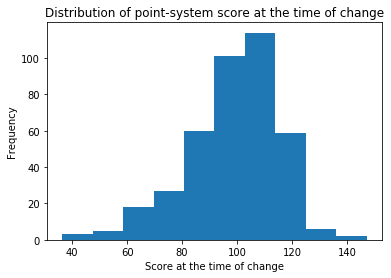

In [44]:
changes=X_test.loc[y_test==1]

plt.hist(changes.score)
plt.title('Distribution of point-system score at the time of change')
plt.xlabel('Score at the time of change')
plt.ylabel('Frequency')
plt.show()